## SVM (Support Vector Maschine) at Titanic Data
Import libs

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder
from sklearn.compose import ColumnTransformer
warnings.filterwarnings("ignore")

## Read Data

In [2]:
df = pd.read_csv("data/train.csv", sep=",", index_col=0)

In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Examing Data

In [4]:
df["Title"]=df.Name.str.split(",",expand=True)[1].str.split(".",expand=True)[0].str.strip()
df["ClassSex"]=df["Pclass"].apply(str)+ df["Sex"]

In [5]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Title         0
ClassSex      0
dtype: int64

### Creating column ClassSex for filling NAN Age with mean by class and sex

In [6]:
mean_age=df.groupby(["ClassSex"]).Age.mean()
mean_age.index

Index(['1female', '1male', '2female', '2male', '3female', '3male'], dtype='object', name='ClassSex')

In [7]:
df2=df[df.Age.isna()]
for item in mean_age.index:
    
    df2.loc[df2["ClassSex"]==item,"Age"]=mean_age[item]
df[df.Age.isna()]=df2

In [8]:
title_dic= {'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Miss','Miss':'Miss',
            'Lady':'Mrs','Mrs':'Mrs','the Countess':'Mrs','Dona':'Mrs',
            'Rev':'Mr','Sir':'Mr','Mr':'Mr','Dr':'Mr','Major':'Mr','Col':'Mr', 'Capt':'Mr','Don':'Mr','Jonkheer':'Mr',
            'Master':'Master',
           }

In [9]:
df.replace({'Title':title_dic},inplace=True)

## Creating Catigory and Number pipes and feature transformer

In [10]:
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         OneHotEncoder(sparse=False, handle_unknown="ignore")
)

In [11]:
num_pipe = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

In [12]:
feature_transform = ColumnTransformer([
    ("Drop Column", 'drop', ['Cabin', 'Name', 'Ticket','ClassSex']),
    ("Cat preprossing", cat_pipe, ['Sex', 'Embarked','Title']),
    ("Num preprossing", num_pipe, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])
])

## Split DF in y and X Data and in Train and Validation Data

In [13]:
y=df["Survived"]
X=df.drop(["Survived"],axis=1)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=1000)


In [15]:
X_train.shape, y_train.shape

((712, 12), (712,))

## Fill NaN and Transform Strings to numbers

In [16]:
X_train_trans = feature_transform.fit_transform(X_train)

In [17]:
X_train_trans.shape

(712, 14)

## Load Define and Train Model for Logistic Regression

In [18]:
from sklearn.svm import SVC

In [29]:
model = SVC(probability=True) 

In [30]:
model.fit(X_train_trans, y_train)

SVC(probability=True)

## Presition Score on Test data 

In [31]:
model.score(X_train_trans, y_train)

0.8384831460674157

## Presition Score on Validation data

In [32]:
X_val_trans = feature_transform.transform(X_val)

In [33]:
model.score(X_val_trans, y_val)

0.8491620111731844

## Crossvalidation

In [34]:
from sklearn.model_selection import cross_val_score 

In [35]:
cross_val_log = cross_val_score(model,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="accuracy"
)

In [36]:
cross_val_log,cross_val_log.mean()

(array([0.81818182, 0.8041958 , 0.84507042, 0.84507042, 0.83098592]),
 0.8287008765882005)

## The Presition probapillity from the Model at Trainig data

In [37]:
model.predict_proba(X_train_trans)

array([[0.84315914, 0.15684086],
       [0.1203389 , 0.8796611 ],
       [0.84331636, 0.15668364],
       ...,
       [0.87013548, 0.12986452],
       [0.82696423, 0.17303577],
       [0.0312504 , 0.9687496 ]])

## Intercept

In [40]:
model.intercept_

array([-0.15567573])

## Accuracy is equal Score

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
y_pred = model.predict(X_train_trans)

In [43]:
accuracy_score(y_train, y_pred)

0.8384831460674157

## Difining Percision Recall and F1 Score 

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [45]:
print(f"""precision = {round(precision_score(y_train,y_pred),2)} \n 
recall = {round(recall_score(y_train,y_pred),2)}\n
f1 = {round(f1_score(y_train,y_pred),2)}""")

precision = 0.87 
 
recall = 0.67

f1 = 0.75


## Confision Matrix off True Positiv/Nagativ and False Positiv/Negativ

In [46]:
from sklearn.metrics import  confusion_matrix,ConfusionMatrixDisplay

In [47]:
confusion_matrix(y_train, y_pred,labels=model.classes_)

array([[422,  27],
       [ 88, 175]])

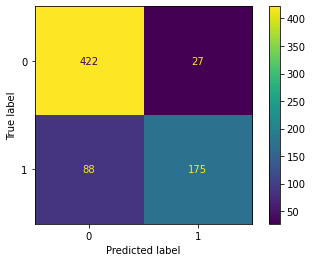

In [48]:
ConfusionMatrixDisplay.from_estimator(model,X_train_trans,y_train)


## Reciever operating curve (ROC) and Area under the curve (AUC) 

In [49]:
from sklearn.metrics import roc_curve,auc ,RocCurveDisplay

In [50]:
probs_train = model.predict_proba(X_train_trans)
probs_train

array([[0.84315914, 0.15684086],
       [0.1203389 , 0.8796611 ],
       [0.84331636, 0.15668364],
       ...,
       [0.87013548, 0.12986452],
       [0.82696423, 0.17303577],
       [0.0312504 , 0.9687496 ]])

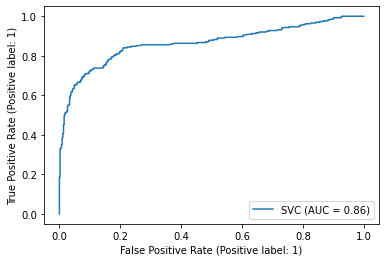

In [51]:
RocCurveDisplay.from_estimator(model,X_train_trans,y_train)

## Getting Flase positiv rate True positive rate and Tresurehold from ROC 

In [52]:
fpr,tpr,tresurehold = roc_curve(y_train,probs_train[:,1])

## Finding best Tresurehold index fron ROC

In [53]:
max_index=np.argmax(tpr-fpr)
max_index

112

In [54]:
tresurehold[max_index]

0.1575328152146822

## get the Area unter the Curve (AUC)

In [55]:
auc(fpr,tpr)

0.8645913606070101

## Get new perdiction with new Tresurehold

In [56]:
prob_train_df=pd.DataFrame(probs_train)

In [82]:
prob_train_df["tresurhold"]=tresurehold[max_index]

In [83]:
prob_train_df.head()

,0,1,tresurhold,new_prediction
0,0.843159,0.156841,0.157533,0
1,0.120339,0.879661,0.157533,1
2,0.843316,0.156684,0.157533,0
3,0.805966,0.194034,0.157533,0
4,0.843457,0.156543,0.157533,0


In [84]:
prob_train_df["new_prediction"]=(prob_train_df[1]>prob_train_df["tresurhold"]).astype(int)

In [85]:
prob_train_df.head()

,0,1,tresurhold,new_prediction
0,0.843159,0.156841,0.157533,0
1,0.120339,0.879661,0.157533,1
2,0.843316,0.156684,0.157533,0
3,0.805966,0.194034,0.157533,1
4,0.843457,0.156543,0.157533,0


## Differentce from new (0.15753281) and old (.5)  Tresurehold on Testdata

In [86]:
acc_test=[]

In [87]:
acc_test.append(accuracy_score(y_train, model.predict(X_train_trans)))

In [88]:
acc_test.append(accuracy_score(y_train, prob_train_df["new_prediction"]))

In [89]:
acc_test

[0.8384831460674157, 0.8075842696629213]

<AxesSubplot:>

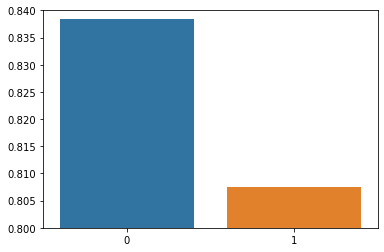

In [93]:
plt.axis((0,1,.8,.84))
sns.barplot([0,1],acc_test)

## Differentce from new (0.15753281) and old (.5) Tresurehold on Valuation Data

In [94]:
props_val = model.predict_proba(X_val_trans)

In [95]:
prob_val_df = pd.DataFrame(props_val)

In [96]:
prob_val_df["tresurhold"]=tresurehold[max_index]

In [97]:
prob_val_df["new_prediction"]=(prob_val_df[1]>prob_val_df["tresurhold"]).astype(int)

In [98]:
acc_val= []

In [99]:
acc_val.append(accuracy_score(y_val,model.predict(X_val_trans)))

In [100]:
acc_val.append(accuracy_score(y_val,prob_val_df["new_prediction"]))

In [101]:
acc_val

[0.8491620111731844, 0.7541899441340782]

<AxesSubplot:>

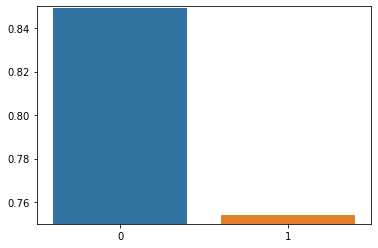

In [103]:
plt.axis((0,1,.75,.85))
sns.barplot([0,1],acc_val)

## Creating datafile for Kaggle

In [104]:
test = pd.read_csv("data/test.csv",sep=",",index_col = 0)
test["Title"]=test.Name.str.split(",",expand=True)[1].str.split(".",expand=True)[0].str.strip()
test["ClassSex"]=test["Pclass"].apply(str)+ df["Sex"]
df2=test[test.Age.isna()]
for item in mean_age.index:
    df2.loc[df2["ClassSex"]==item,"Age"]=mean_age[item]
test[test.Age.isna()]=df2
test.replace({'Title':title_dic},inplace=True)
test_trans = feature_transform.transform(test)
test_pred = model.predict(test_trans)
test_props_val = model.predict_proba(test_trans)
test_prob_val_df = pd.DataFrame(test_props_val)
test_prob_val_df["tresurhold"]=tresurehold[max_index]
test_prob_val_df["new_prediction"]=(test_prob_val_df[1]>test_prob_val_df["tresurhold"]).astype(int)
kraggle = pd.DataFrame(test.index)
kraggle["Survived"]=test_pred#test_prob_val_df["new_prediction"]
kraggle.set_index("PassengerId")
kraggle.to_csv("data/kraggle_SVM.csv",index = False)